# What causes flanking pairs to be reactive?

# Setup

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from tabulate import tabulate

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    format_small_plot,
)

## extra functions

## load data

In [2]:
DATA_PATH = "../data"

In [3]:
df_constructs = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1_combined.json"
)
df_constructs_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df = df.query("r_data_outlier == False").copy()
df_wc = df.query("r_type == 'WC'").copy()

df_wc.sort_values("ln_r_data", inplace=True, ascending=False)
df_wc_high = df_wc.query("ln_r_data > -5.45").copy()
df_wc_high.sort_values("ln_r_data", inplace=True, ascending=False)

# TODO better understand how we got this data and howa to replicate it
# At the moment only look at flanking pairs
df_bp_details = pd.read_csv(f"../dms_3d_features/resources/csvs/wc_details.csv")
df_bp_details = df_bp_details.query("flanking_pairs == 'YES'")
df_bp_details["ln_r_data"] = np.log(df["r_data"])

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# plotting and analysis

## trends over all flanking nucleotides

### As are more reactive than Cs in flanking pairs

As are more reactive than Cs in flanking pairs even though there are more Cs flanking pairs in general

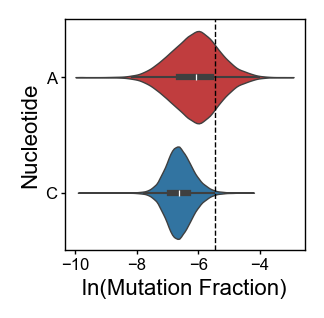

In [4]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = sns.violinplot(
    data=df_wc,
    x="ln_r_data",
    y="r_nuc",
    hue="r_nuc",
    density_norm="width",
    palette=["tab:red", "tab:blue"],
    legend=False,
    linewidth=0.5,
    ax=ax,
)
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
ax.set_ylabel("Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4])
format_small_plot(ax)

#### There are 19% reactive As and 1% reactive Cs for flanking pairs

In [5]:
for r_nuc, g in df_wc.groupby("r_nuc"):
    g_sub = g.query("ln_r_data > -5.45")
    print(r_nuc, round(len(g_sub) / len(g) * 100, 2), len(g))

A 19.56 47652
C 1.01 52121


#### if we consider only those with pdbs, there are still more reactive As

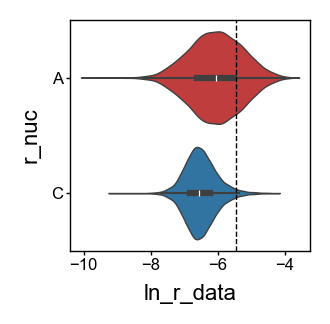

In [6]:
df_wc_pdb = df_wc.query("has_pdbs == True").copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = sns.violinplot(
    data=df_wc_pdb,
    x="ln_r_data",
    y="r_nuc",
    hue="r_nuc",
    density_norm="width",
    palette=["tab:red", "tab:blue"],
    legend=False,
    linewidth=0.5,
    ax=ax,
)
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5),
ax.set_xticks([-10, -8, -6, -4])
publication_style_ax(ax)
format_small_plot(ax)

#### This trend is only seen in WC pairs not over all residues.

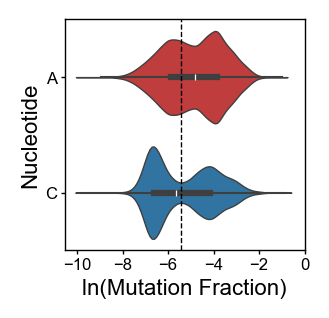

In [7]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
sns.violinplot(
    data=df,
    x="ln_r_data",
    y="r_nuc",
    hue="r_nuc",
    density_norm="width",
    palette=["tab:red", "tab:blue"],
    legend=False,
    linewidth=0.5,
    ax=ax,
)
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
ax.set_ylabel("Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2, 0])
publication_style_ax(ax)
format_small_plot(ax)

## How do structural features of flanking pairs correlate with reactivity?

There doesnt seem to me much correlation between reactivity and the number of extra nucleotides in flanking pairs

In [8]:
def get_pearson_r2_correlations(df, target_column, feature_columns):
    """
    Calculate Pearson R^2 correlations between a target column and specified feature columns.

    Args:
    df (pandas.DataFrame): The input DataFrame
    target_column (str): The name of the target column
    feature_columns (list): List of feature column names to correlate with the target

    Returns:
    dict: A dictionary with feature names as keys and their R^2 values as values
    """
    from scipy import stats

    correlations = {}
    for feature in feature_columns:
        r, _ = stats.pearsonr(df[target_column], df[feature])
        r2 = r**2
        correlations[feature] = r2

    return correlations


def print_feature_correlations(df):
    feature_columns = [
        "shear",
        "stretch",
        "stagger",
        "buckle",
        "propeller",
        "opening",
        "rmsd_from_ideal",
    ]
    correlations = get_pearson_r2_correlations(df, "r_data", feature_columns)

    # Prepare data for tabulate
    table_data = [[feature, f"{r2:.3f}"] for feature, r2 in correlations.items()]
    headers = ["Feature", "R^2 with ln_r_data"]

    # Print the results using tabulate
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))

In [9]:
print_feature_correlations(df_bp_details)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0     |
| stretch         |                0.003 |
| stagger         |                0.002 |
| buckle          |                0.002 |
| propeller       |                0     |
| opening         |                0.001 |
| rmsd_from_ideal |                0.004 |


In [10]:
df_bp_details_sub = df_bp_details.query("bp == 'AU'").copy()
print_feature_correlations(df_bp_details_sub)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0.006 |
| stretch         |                0.001 |
| stagger         |                0.001 |
| buckle          |                0.001 |
| propeller       |                0.007 |
| opening         |                0.001 |
| rmsd_from_ideal |                0.01  |


In [11]:
df_bp_details_sub = df_bp_details.query("bp == 'UA'").copy()
print_feature_correlations(df_bp_details_sub)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0     |
| stretch         |                0     |
| stagger         |                0.052 |
| buckle          |                0.001 |
| propeller       |                0.005 |
| opening         |                0.017 |
| rmsd_from_ideal |                0.002 |


In [12]:
df_bp_details_sub = df_bp_details.query("bp == 'CG'").copy()
print_feature_correlations(df_bp_details_sub)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0.003 |
| stretch         |                0     |
| stagger         |                0.001 |
| buckle          |                0     |
| propeller       |                0     |
| opening         |                0.003 |
| rmsd_from_ideal |                0.002 |


In [13]:
df_bp_details_sub = df_bp_details.query("bp == 'GC'").copy()
print_feature_correlations(df_bp_details_sub)

| Feature         |   R^2 with ln_r_data |
|:----------------|---------------------:|
| shear           |                0.001 |
| stretch         |                0.001 |
| stagger         |                0     |
| buckle          |                0.002 |
| propeller       |                0.001 |
| opening         |                0     |
| rmsd_from_ideal |                0.002 |


## How does the reactivity for A and C flanking pairs compare compare by different junction topologies?

### looking at all topologies

General trends are that for topologies that are more uneven are more reactive on average than those are are even<br><br>
This holds true for both As and Cs although the effect is much stronger for As

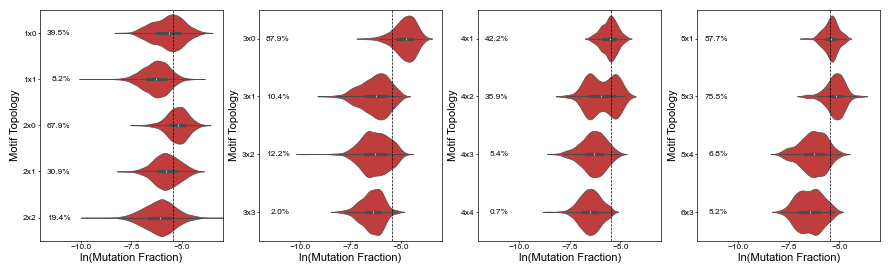

In [14]:
def plot_violins_by_groups(
    df, group_col, x_col, y_col, color, n_panels=2, figsize=(3.5, 3), dpi=100
):
    df = df.copy()
    df.sort_values(group_col, inplace=True, ascending=True)

    # Split groups into n_panels
    groups = df[group_col].unique()
    group_splits = np.array_split(groups, n_panels)

    # Create subplots
    fig, axes = plt.subplots(
        1, n_panels, figsize=(figsize[0] * n_panels, figsize[1]), dpi=dpi
    )
    if n_panels == 1:
        axes = [axes]

    for i, (ax, group_split) in enumerate(zip(axes, group_splits)):
        sns.violinplot(
            data=df[df[group_col].isin(group_split)],
            x=x_col,
            y=group_col,
            density_norm="width",
            color=color,
            ax=ax,
            linewidth=0.5,
        )
        ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
        ax.set_ylabel("Motif Topology", labelpad=2)
        ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
        ax.set_xlim(-12, -3)
        # Calculate and add percentage labels
        for idx, group in enumerate(group_split):
            group_data = df[df[group_col] == group][x_col]
            percent_over = (group_data > -5.45).mean() * 100
            ax.text(
                ax.get_xlim()[0] + 1.5,
                idx,
                f"{percent_over:.1f}%",
                va="center",
                ha="right",
                fontsize=10,
            )

        format_small_plot(ax)


# Usage
df_pos = df_wc.query("r_nuc == 'A'").copy()
plot_violins_by_groups(df_pos, "m_token", "ln_r_data", "m_token", "tab:red", n_panels=4)

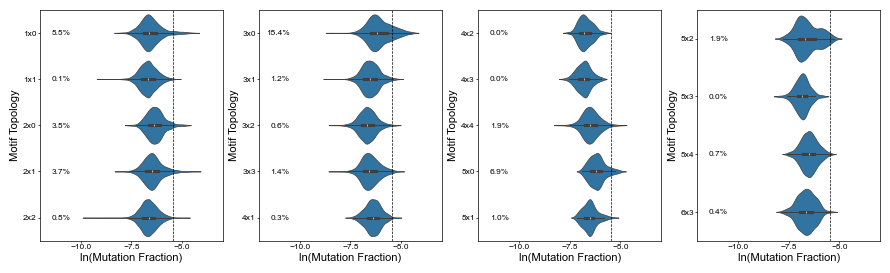

In [15]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
plot_violins_by_groups(
    df_pos, "m_token", "ln_r_data", "m_token", "tab:blue", n_panels=4
)

In [16]:
# Calculate percentage of entries over -5.45 for each m_token and total count
def calculate_and_format_percent_over_threshold(df_wc):
    df_wc_percent = (
        df_wc.groupby("m_token")
        .agg(
            {
                "ln_r_data": [
                    (
                        "percent_over_threshold",
                        lambda x: round((x > -5.45).mean() * 100, 2),
                    ),
                    ("total_entries", "count"),
                ]
            }
        )
        .reset_index()
    )
    # Format the table with headers and better styling
    table = tabulate(
        df_wc_percent,
        headers=["junction topology", "percent over threshold", "total entries"],
        tablefmt="pretty",
        floatfmt=".2f",
        numalign="right",
        showindex=False,
    )
    return table


df_pos = df_wc.query("r_nuc == 'A'").copy()
print("A reactivity of flanking As by junction topology")
print(calculate_and_format_percent_over_threshold(df_pos))
# Sort the dataframe by percentage in descending order

A reactivity of flanking As by junction topology
+-------------------+------------------------+---------------+
| junction topology | percent over threshold | total entries |
+-------------------+------------------------+---------------+
|        1x0        |         39.53          |      387      |
|        1x1        |          8.18          |     2434      |
|        2x0        |         67.89          |      383      |
|        2x1        |         30.86          |      324      |
|        2x2        |         19.43          |     40904     |
|        3x0        |         87.93          |      174      |
|        3x1        |         10.41          |      538      |
|        3x2        |         12.16          |      510      |
|        3x3        |          1.95          |      307      |
|        4x1        |         42.16          |      204      |
|        4x2        |         35.92          |      103      |
|        4x3        |          5.37          |      410      |
|     

In [17]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
print("A reactivity of flanking Cs by junction topology")
print(calculate_and_format_percent_over_threshold(df_pos))

A reactivity of flanking Cs by junction topology
+-------------------+------------------------+---------------+
| junction topology | percent over threshold | total entries |
+-------------------+------------------------+---------------+
|        1x0        |          5.46          |      549      |
|        1x1        |          0.13          |     2375      |
|        2x0        |          3.5           |      257      |
|        2x1        |          3.7           |     2083      |
|        2x2        |          0.54          |     39514     |
|        3x0        |         15.43          |      784      |
|        3x1        |          1.17          |      857      |
|        3x2        |          0.56          |     1430      |
|        3x3        |          1.39          |     1221      |
|        4x1        |          0.33          |      304      |
|        4x2        |          0.0           |      152      |
|        4x3        |          0.0           |      102      |
|     

### compare number of extra nucleotides on each side which appears to be correlated with reactivity in flanking pairs

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Diff. in num nucleotides'>)

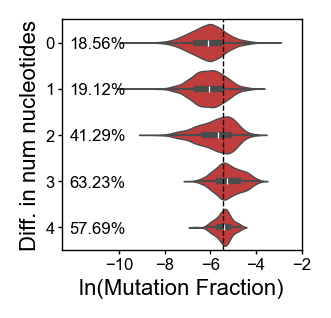

In [18]:
def plot_side_diff_violinplot(df_pos, color="tab:red"):
    df_pos["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]
    ]
    df_pos["side_diff"] = df_pos["side_diff"].astype(str)
    df_pos.sort_values("side_diff", inplace=True, ascending=True)

    # Calculate percentage over threshold for each side_diff
    percentages = (
        df_pos.groupby("side_diff")
        .apply(lambda x: (x["ln_r_data"] > -5.45).mean() * 100)
        .round(2)
    )

    fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
    ax = sns.violinplot(
        data=df_pos,
        x="ln_r_data",
        y="side_diff",
        density_norm="width",
        color=color,
        linewidth=0.5,
        ax=ax,
    )
    ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
    ax.set_xlim(-12.5, -3)
    ax.set_xticks([-10, -8, -6, -4, -2])
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Diff. in num nucleotides", labelpad=2)
    # Add percentage labels
    for i, (side_diff, percentage) in enumerate(percentages.items()):
        ax.text(-9.7, i + 0.03, f"{percentage:.2f}%", va="center", ha="right")
    format_small_plot(ax)

    return fig, ax


df_pos = df_wc.query("r_nuc == 'A' and m_token != '6x3'").copy()
plot_side_diff_violinplot(df_pos)

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Diff. in num nucleotides'>)

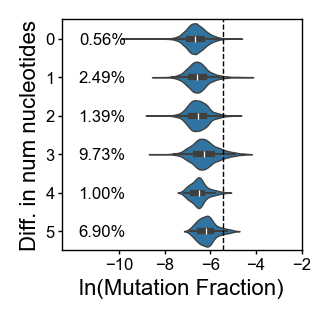

In [19]:
df_pos = df_wc.query("r_nuc == 'C' and m_token != '6x3'").copy()
plot_side_diff_violinplot(df_pos, color="tab:blue")

## How does sequence and stacking correlate with reactivity of flanking residues

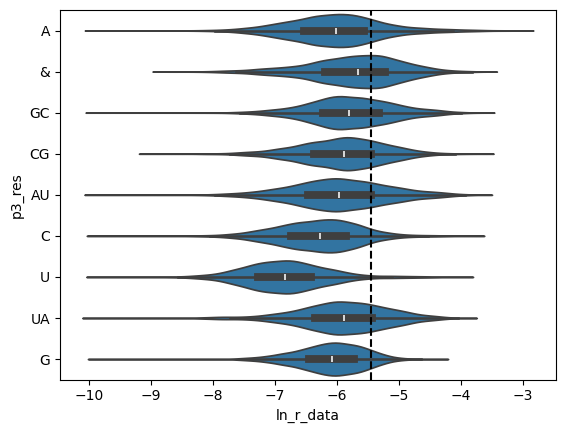

In [20]:
df_pos = df_wc.query("r_nuc == 'A'").copy()
ax = sns.violinplot(
    data=df_pos, x="ln_r_data", y="p3_res", density_norm="width", legend=False
)
ax.axvline(-5.45, color="black", linestyle="--")

### position 1 analysis

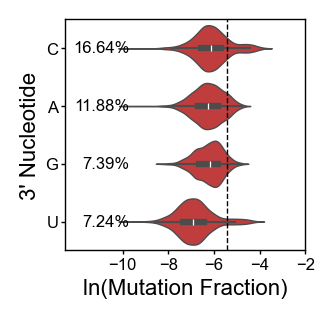

In [21]:
df_pos = df_wc.query("r_loc_pos == 0 and r_nuc == 'A'").copy()

# Calculate percentages
percentages = {}
for p3_res in df_pos["p3_res"].unique():
    group = df_pos[df_pos["p3_res"] == p3_res]
    percentages[p3_res] = (group["ln_r_data"] > -5.45).mean() * 100

# Sort p3_res by percentage
sorted_p3_res = sorted(percentages.keys(), key=lambda x: percentages[x], reverse=True)

fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
sns.violinplot(
    data=df_pos,
    x="ln_r_data",
    y="p3_res",
    density_norm="width",
    color="tab:red",
    linewidth=0.5,
    order=sorted_p3_res,
    ax=ax,
)
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)

# Add percentage labels
for i, p3_res in enumerate(sorted_p3_res):
    ax.text(-9.7, i, f"{percentages[p3_res]:.2f}%", va="center", ha="right")

ax.set_xlim(-12.5, -3)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("3' Nucleotide", labelpad=2)
format_small_plot(ax)

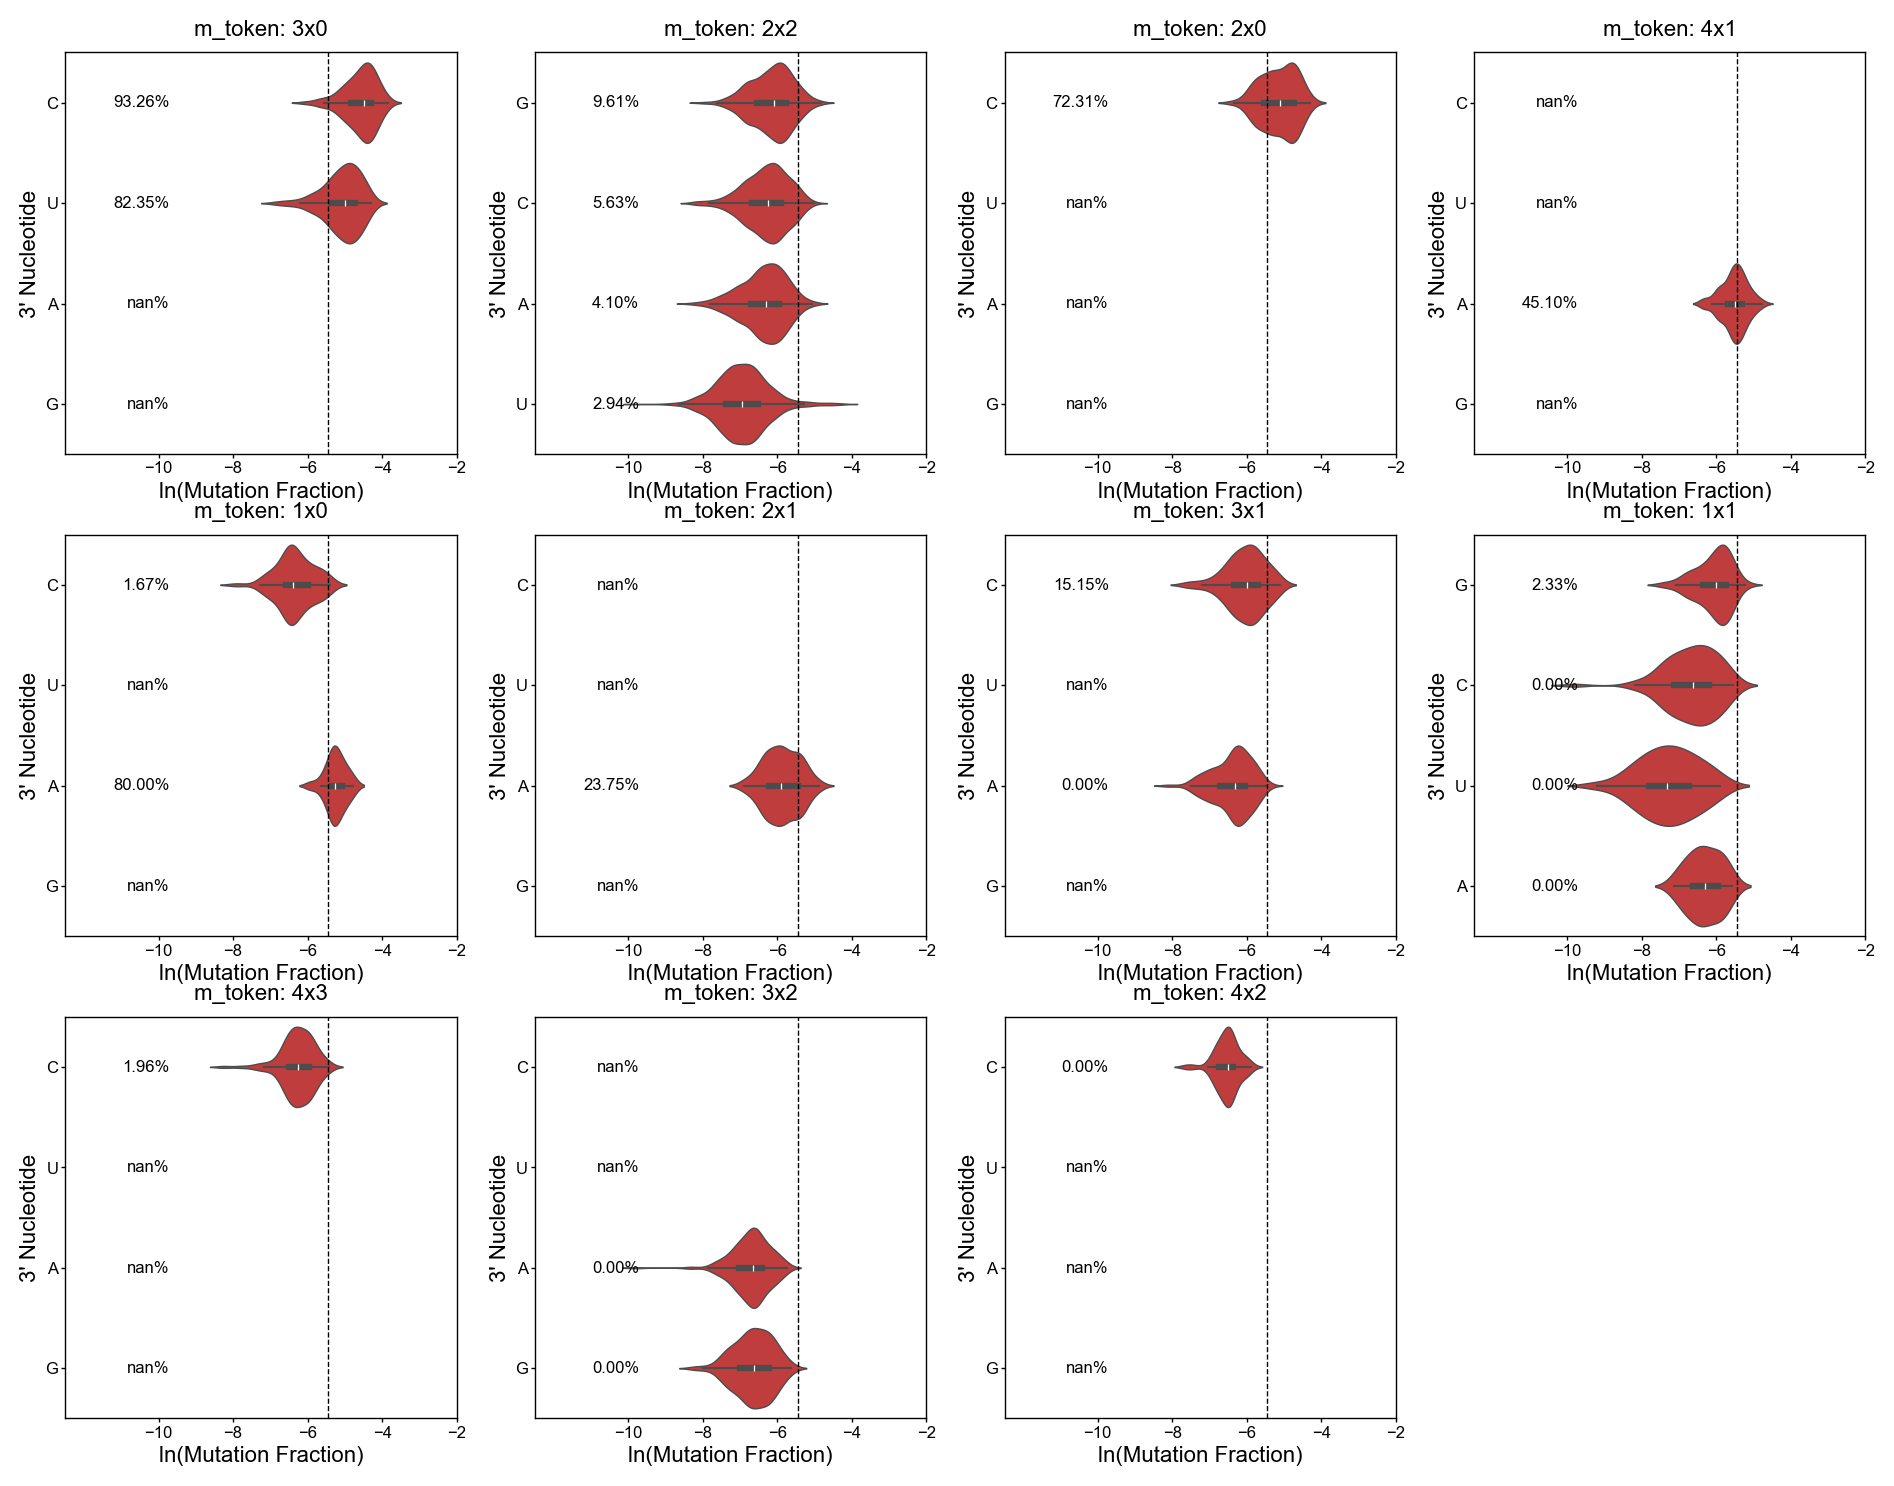

In [22]:
# Function to calculate percentages for each p3_res within each m_token
def calculate_percentages(df):
    percentages = {}
    for m_token in df["m_token"].unique():
        percentages[m_token] = {}
        for p3_res in df["p3_res"].unique():
            group = df[(df["m_token"] == m_token) & (df["p3_res"] == p3_res)]
            percentages[m_token][p3_res] = (group["ln_r_data"] > -5.45).mean() * 100
    return percentages


# Filter data
df_pos = df_wc.query("r_loc_pos == 0 and r_nuc == 'A'").copy()

# Calculate percentages
percentages = calculate_percentages(df_pos)

# Create the plot
fig, axes = plt.subplots(4, 4, figsize=(15, 12), dpi=200)
axes = axes.flatten()

for idx, (m_token, p3_res_percentages) in enumerate(percentages.items()):
    if idx >= len(axes):
        break
    ax = axes[idx]

    # Sort p3_res by percentage
    sorted_p3_res = sorted(
        p3_res_percentages.keys(), key=lambda x: p3_res_percentages[x], reverse=True
    )

    # Create violin plot for each m_token
    sns.violinplot(
        data=df_pos[df_pos["m_token"] == m_token],
        x="ln_r_data",
        y="p3_res",
        density_norm="width",
        color="tab:red",
        linewidth=0.5,
        order=sorted_p3_res,
        ax=ax,
    )

    ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)

    # Add percentage labels
    for i, p3_res in enumerate(sorted_p3_res):
        ax.text(-9.7, i, f"{p3_res_percentages[p3_res]:.2f}%", va="center", ha="right")

    ax.set_xlim(-12.5, -3)
    ax.set_xticks([-10, -8, -6, -4, -2])
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("3' Nucleotide", labelpad=2)
    ax.set_title(f"m_token: {m_token}")
    format_small_plot(ax)

# Remove any unused subplots
for idx in range(len(percentages), len(axes)):
    fig.delaxes(axes[idx])

In [23]:
df_pos = df_wc.query("r_loc_pos == 0 and r_nuc == 'A'").copy()
table_data = []

for stack, g in df_pos.query("r_nuc == 'A'").groupby("p3_res"):
    g_sub = g.query("ln_r_data > -5.45")
    total_count = len(g)
    reactive_count = len(g_sub)
    percentage = (reactive_count / total_count) * 100
    table_data.append([stack, total_count, reactive_count, percentage])

headers = ["3' Nucleotide", "Total Count", "Reactive Count", "Percentage (%)"]
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".2f"))

+-----------------+---------------+------------------+------------------+
| 3' Nucleotide   |   Total Count |   Reactive Count |   Percentage (%) |
+=================+===============+==================+==================+
| A               |           766 |               91 |            11.88 |
+-----------------+---------------+------------------+------------------+
| C               |          1070 |              178 |            16.64 |
+-----------------+---------------+------------------+------------------+
| G               |           582 |               43 |             7.39 |
+-----------------+---------------+------------------+------------------+
| U               |          1546 |              112 |             7.24 |
+-----------------+---------------+------------------+------------------+


In [24]:
df_pos = df_wc.query("r_loc_pos == 0").copy()
stack = []
for i, row in df_pos.iterrows():
    stack.append(row["m_second_flank_bp_5p"][0] + row["p3_res"])
df_pos["stack"] = stack

In [25]:
for stack, g in df_pos.query("r_nuc == 'A'").groupby("stack"):
    g_sub = g.query("ln_r_data > -5.45")
    print(stack, len(g_sub) / len(g) * 100)

AA 8.808290155440414
AC 14.285714285714285
AG 6.748466257668712
AU 9.090909090909092
CA 14.906832298136646
CC 19.747899159663866
CG 9.345794392523365
CU 9.118541033434651
GA 20.73170731707317
GC 26.36363636363636
GG 15.238095238095239
GU 9.967845659163988
UA 6.451612903225806
UC 10.427807486631016
UG 2.898550724637681
UU 2.941176470588235


In [26]:
for stack, g in df_pos.query("r_nuc == 'C'").groupby("stack"):
    g_sub = g.query("ln_r_data > -5.45")
    print(stack, len(g_sub) / len(g) * 100)

AA 1.5894039735099337
AC 6.265984654731457
AG 0.6775067750677507
AU 0.0
CA 0.2617801047120419
CC 0.7936507936507936
CG 0.0
CU 0.0
GA 0.2457002457002457
GC 2.3404255319148937
GG 0.819672131147541
GU 0.0
UA 0.5633802816901409
UC 2.4226110363391657
UG 0.6377551020408163
UU 0.0


In [27]:
df_final = df_pos.query("r_nuc == 'A'").copy().sort_values("stack", ascending=True)
df_final["ln_r_data_bins"] = pd.cut(df_final["ln_r_data"], bins=25)

In [28]:
heatmap_data = df_final.pivot_table(
    index="stack", columns="ln_r_data_bins", values="ln_r_data", aggfunc="count"
)

<Axes: xlabel='ln_r_data_bins', ylabel='stack'>

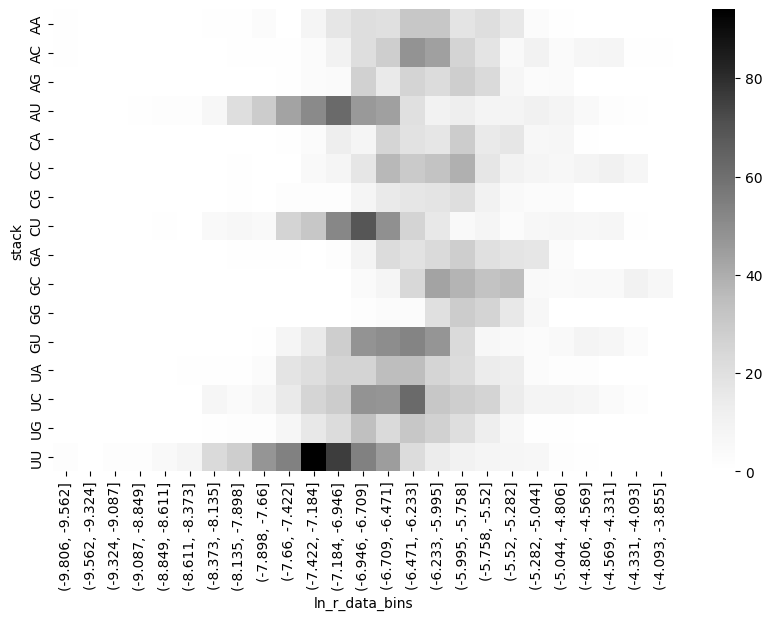

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="Greys")

In [30]:
for stack, g in df_pos.query("r_nuc == 'C'").groupby("stack"):
    g_sub = g.query("ln_r_data > -5.45")
    print(stack, len(g_sub) / len(g) * 100)

AA 1.5894039735099337
AC 6.265984654731457
AG 0.6775067750677507
AU 0.0
CA 0.2617801047120419
CC 0.7936507936507936
CG 0.0
CU 0.0
GA 0.2457002457002457
GC 2.3404255319148937
GG 0.819672131147541
GU 0.0
UA 0.5633802816901409
UC 2.4226110363391657
UG 0.6377551020408163
UU 0.0


/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_70365/1403191068.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(data=df_target, x="ln_r_data", y="stack", scale="width")


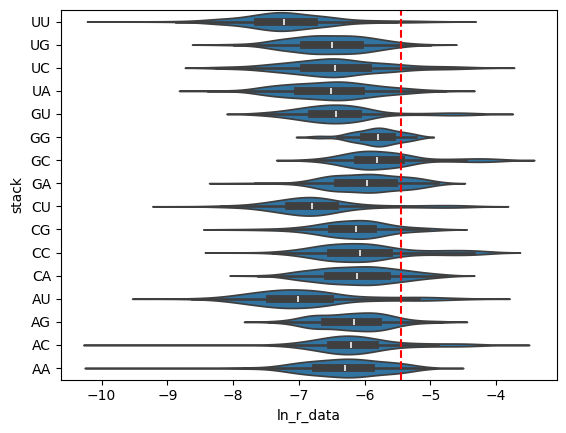

In [31]:
df_target = df_pos.query("r_nuc == 'A'").sort_values("stack", ascending=False)
ax = sns.violinplot(data=df_target, x="ln_r_data", y="stack", scale="width")
ax.axvline(-5.45, color="red", linestyle="--")

## look at the most reactive sequences

In [32]:
first_10_unique = df_wc_high.drop_duplicates(subset="m_sequence", keep="first").head(10)

# Calculate average reactivity for each m_sequence
avg_reactivity = df_wc_high.groupby("m_sequence")["r_data"].mean().reset_index()

# Merge with first_10_unique to get the position information
result = first_10_unique.merge(avg_reactivity, on="m_sequence")

# Create a table with m_sequence, position, and average reactivity
table_data = result[["m_sequence", "r_loc_pos", "r_data_y"]].values.tolist()

# Use tabulate to create a formatted table
print(
    tabulate(
        table_data,
        headers=["m_sequence", "Position", "Avg Reactivity"],
        tablefmt="grid",
    )
)

+--------------+------------+------------------+
| m_sequence   |   Position |   Avg Reactivity |
+==============+============+==================+
| CCAU&AAUG    |          5 |       0.0209033  |
+--------------+------------+------------------+
| CCAU&AACG    |          5 |       0.01488    |
+--------------+------------+------------------+
| UCAU&AAUA    |          5 |       0.0104289  |
+--------------+------------+------------------+
| GCAU&AAUC    |          5 |       0.0109958  |
+--------------+------------+------------------+
| CUGU&AAUG    |          5 |       0.0128355  |
+--------------+------------+------------------+
| UCAU&AACA    |          5 |       0.0102059  |
+--------------+------------+------------------+
| UGAA&UCAA    |          3 |       0.00863218 |
+--------------+------------+------------------+
| UCAG&CAAA    |          8 |       0.0101071  |
+--------------+------------+------------------+
| UAUC&GUGA    |          8 |       0.0128456  |
+--------------+----

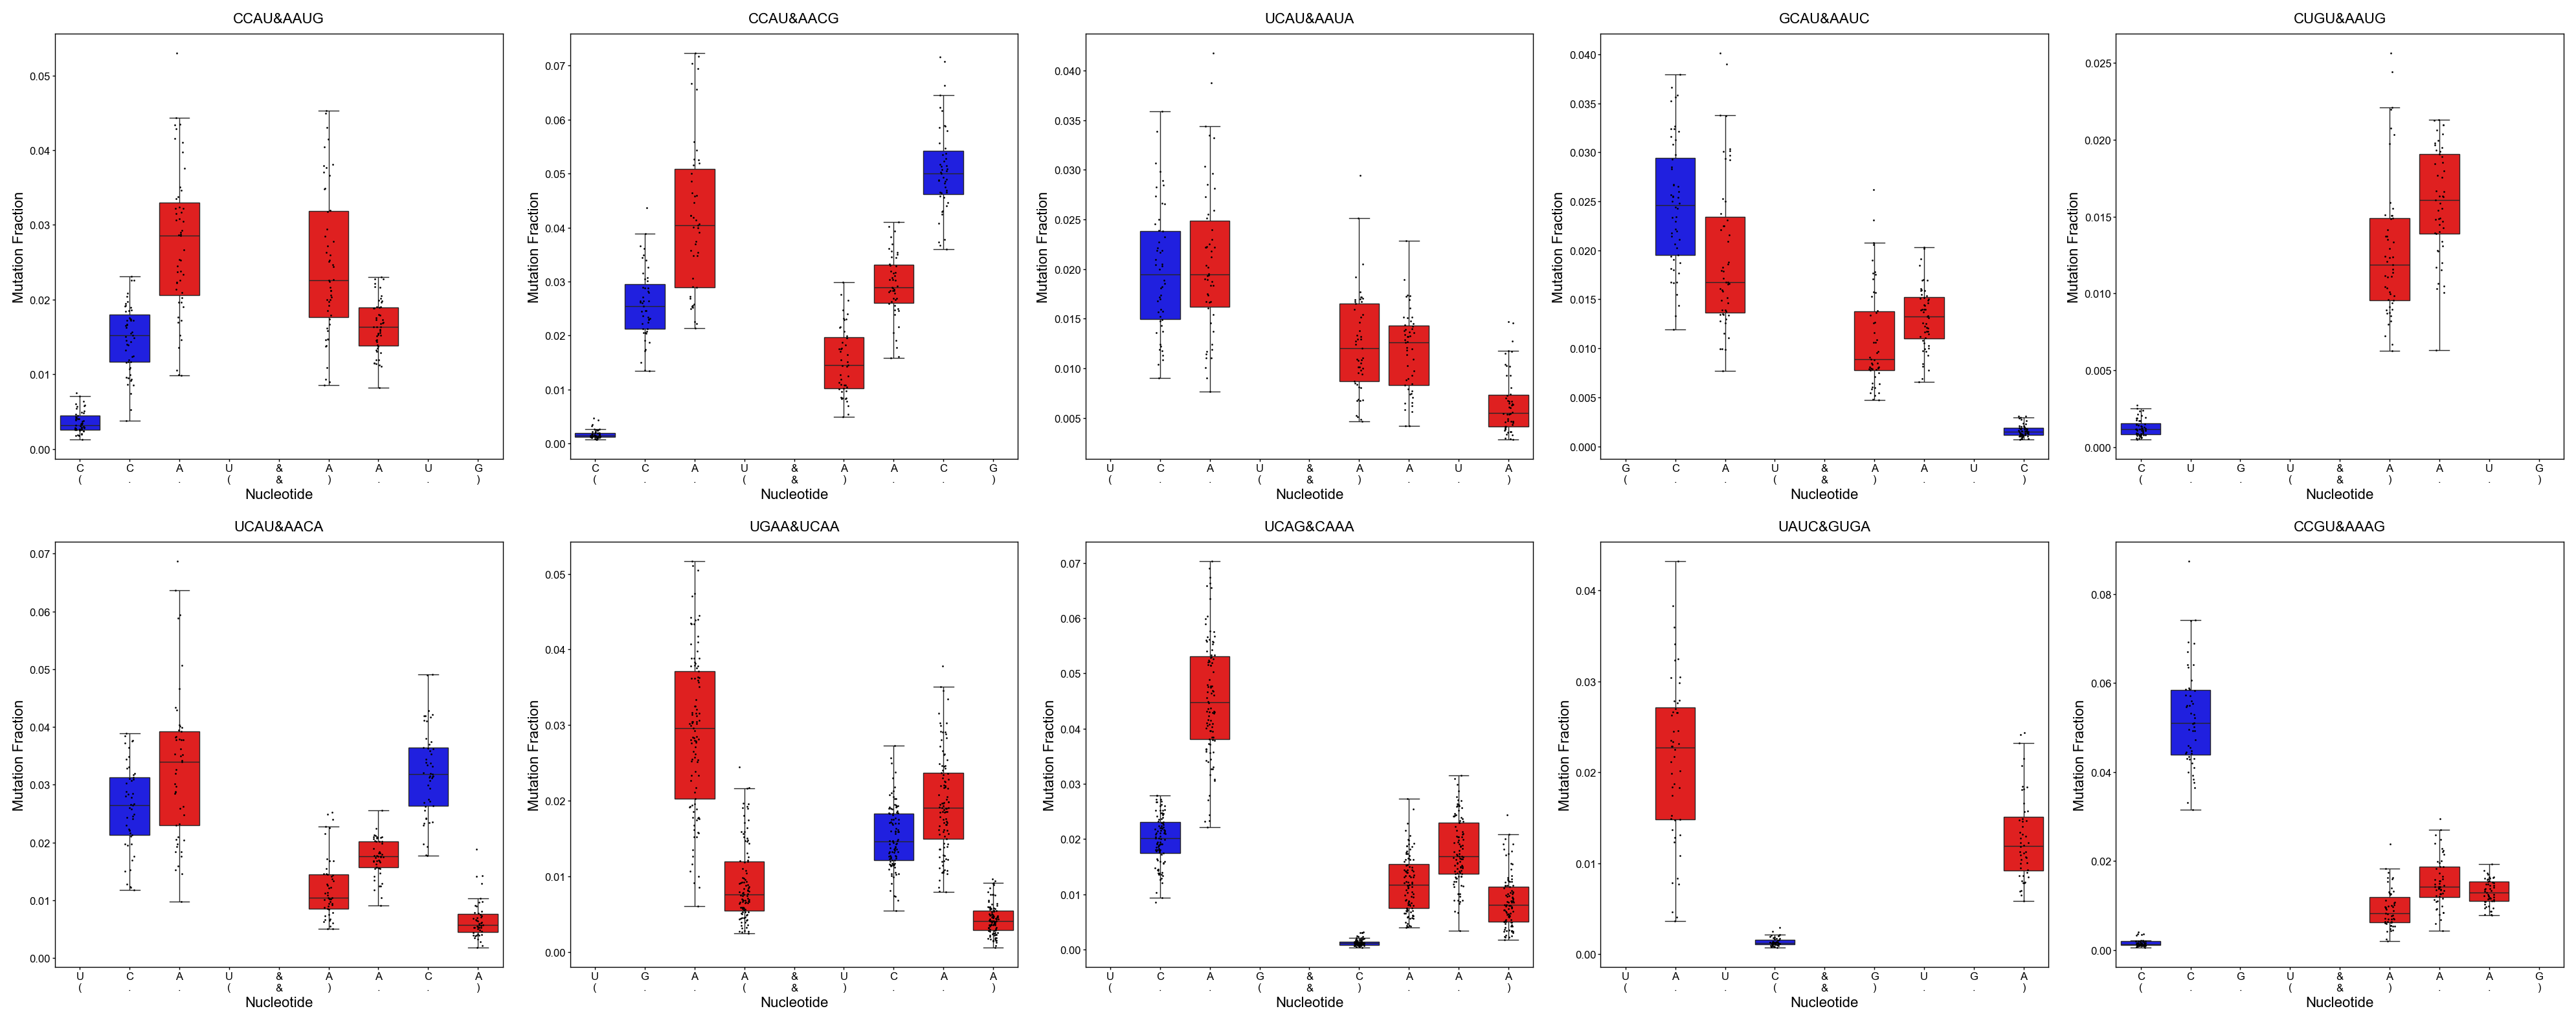

In [33]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=200)
axes = axes.flatten()

top_10_sequences = first_10_unique["m_sequence"].tolist()

for i, sequence in enumerate(top_10_sequences):
    if i < len(axes):  # Add this check to avoid index out of bounds error
        ax = axes[i]
        plot_motif_boxplot_stripplot(
            df.query(f"m_sequence == '{sequence}'"), ax=ax, show_structure=True
        )
        format_small_plot(ax)
        ax.set_title(sequence, fontsize=8)

# Remove any unused subplots
for j in range(len(top_10_sequences), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust the layout to prevent overlapping

#### AGGC&GAAU

In [34]:
df_wc.query("m_sequence == 'AGGC&GAAU' and r_loc_pos == 0 and ln_r_data > -5.45")

,both_purine,both_pyrimidine,constructs,has_pdbs,likely_pair,m_flank_bp_5p,m_flank_bp_3p,m_orientation,m_pos,m_second_flank_bp_5p,...,r_data,r_nuc,r_loc_pos,r_pos,r_type,pdb_path,pdb_r_pos,ln_r_data,z_score,r_data_outlier


<Axes: >

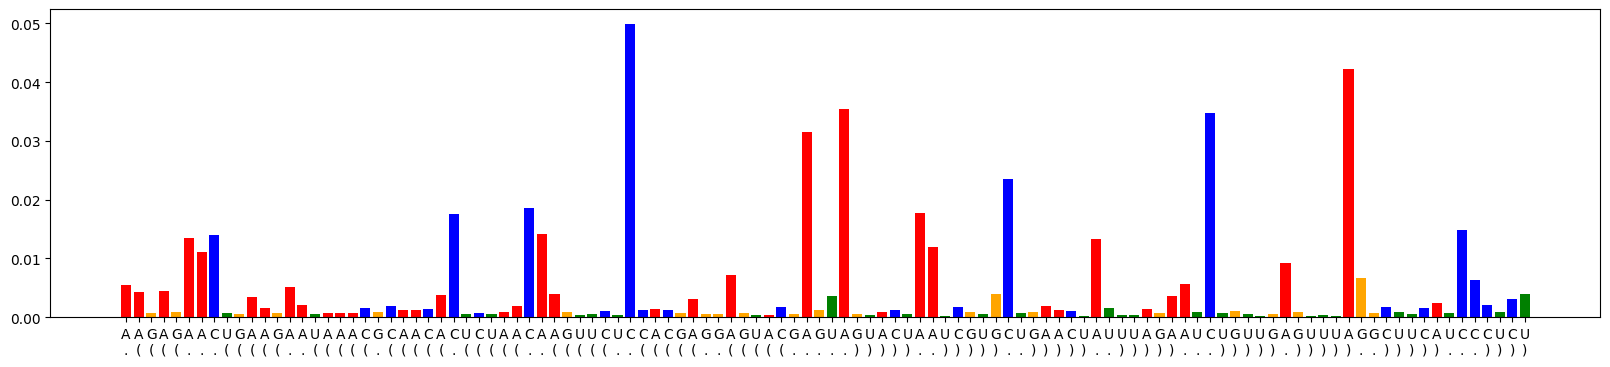

In [35]:
plot_pop_avg_from_row(df_constructs.query('name == "construct1191"').iloc[0])

<Axes: >

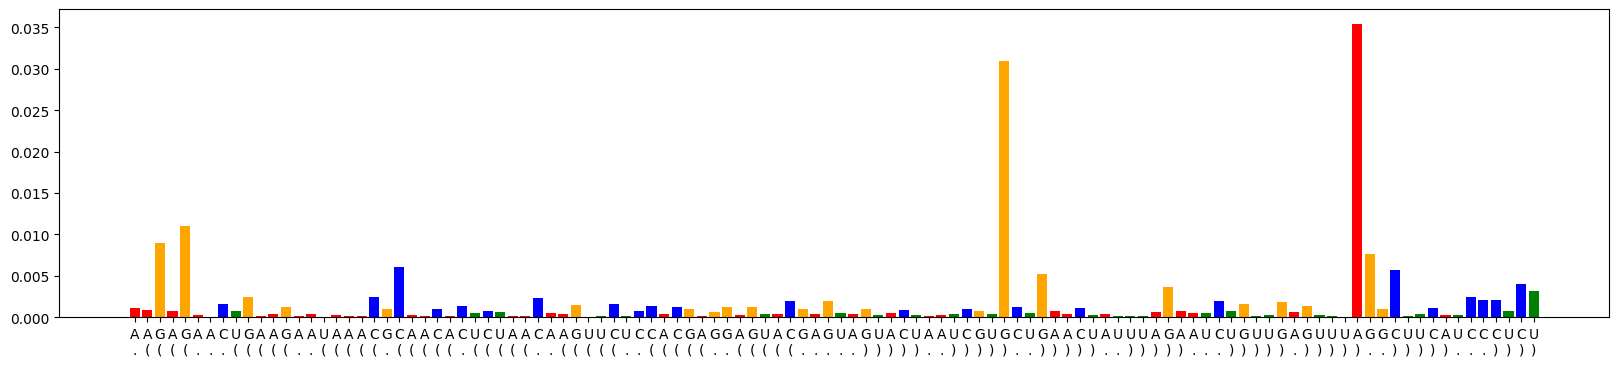

In [36]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct1191"').iloc[0])

In [37]:
df_constructs.query('name == "construct1191"').iloc[0]["sequence"]

'AAGAGAACUGAAGAAUAAACGCAACACUCUAACAAGUUCUCCACGAGGAGUACGAGUAGUACUAAUCGUGCUGAACUAUUUAGAAUCUGUUGAGUUUAGGCUUCAUCCCUCU'

<Axes: >

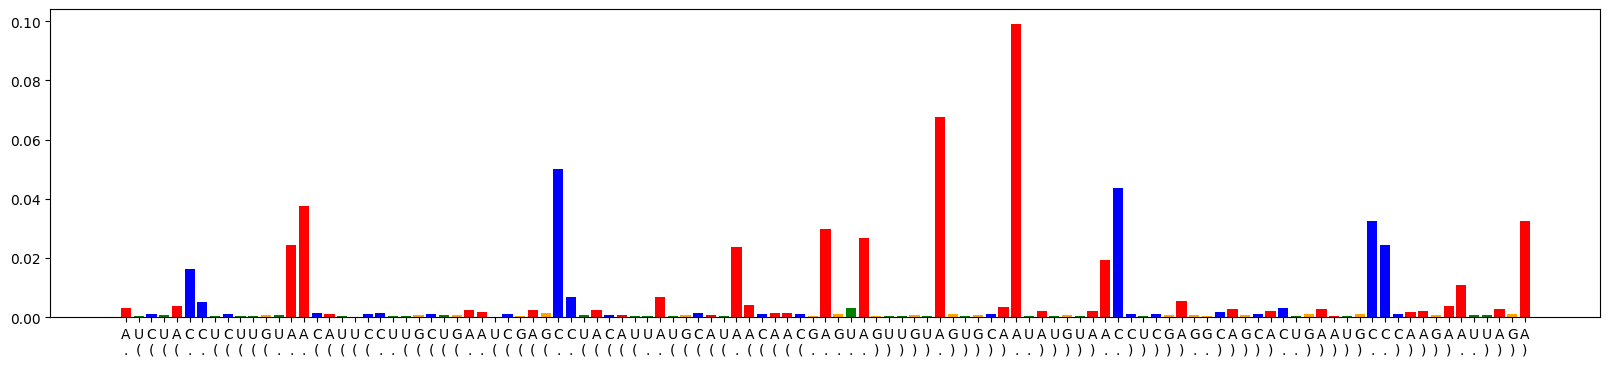

In [38]:
plot_pop_avg_from_row(df_constructs.query('name == "construct3320"').iloc[0])

<Axes: >

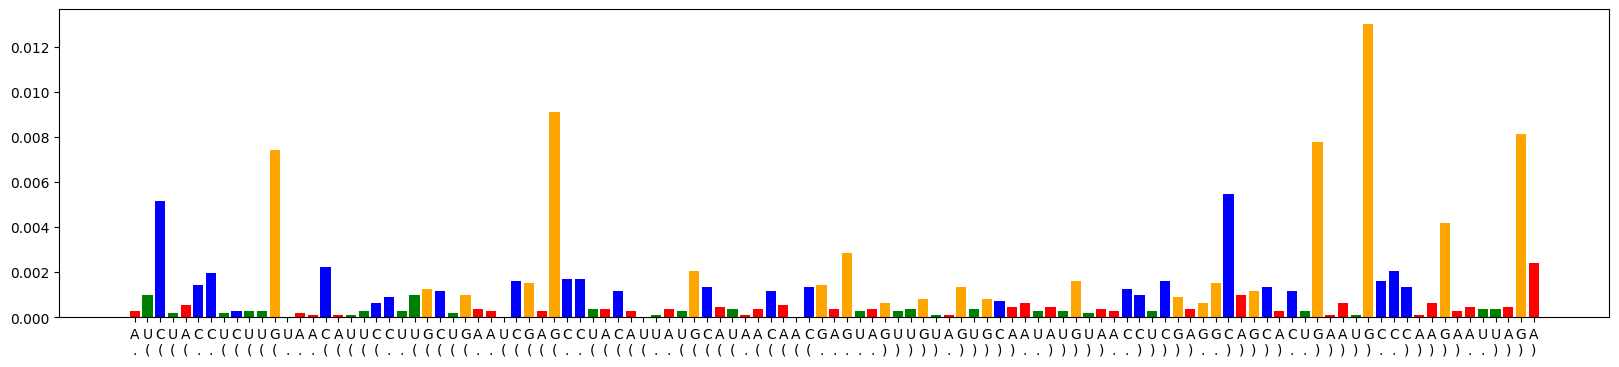

In [39]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct3320"').iloc[0])

In [40]:
df_pos = df_wc.query("m_sequence == 'AGGC&GAAU' and r_loc_pos == 0").copy()

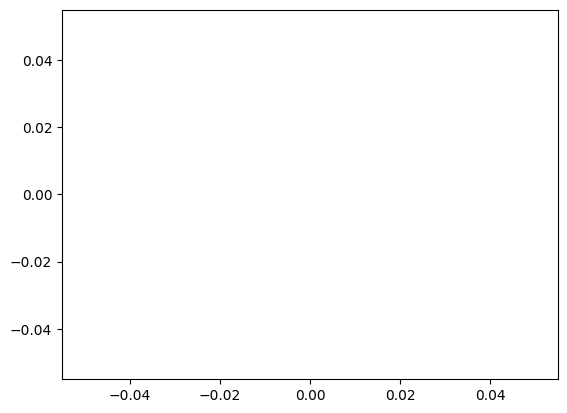

In [41]:
plt.scatter(df_pos["r_data"], df_pos["r_pos"])

#### AAAG&CCGU

In [42]:
df_wc.query("m_sequence == 'AAAG&CCGU' and r_loc_pos == 0 and ln_r_data < -5.45")

,both_purine,both_pyrimidine,constructs,has_pdbs,likely_pair,m_flank_bp_5p,m_flank_bp_3p,m_orientation,m_pos,m_second_flank_bp_5p,...,r_data,r_nuc,r_loc_pos,r_pos,r_type,pdb_path,pdb_r_pos,ln_r_data,z_score,r_data_outlier


(0.0, 0.05)

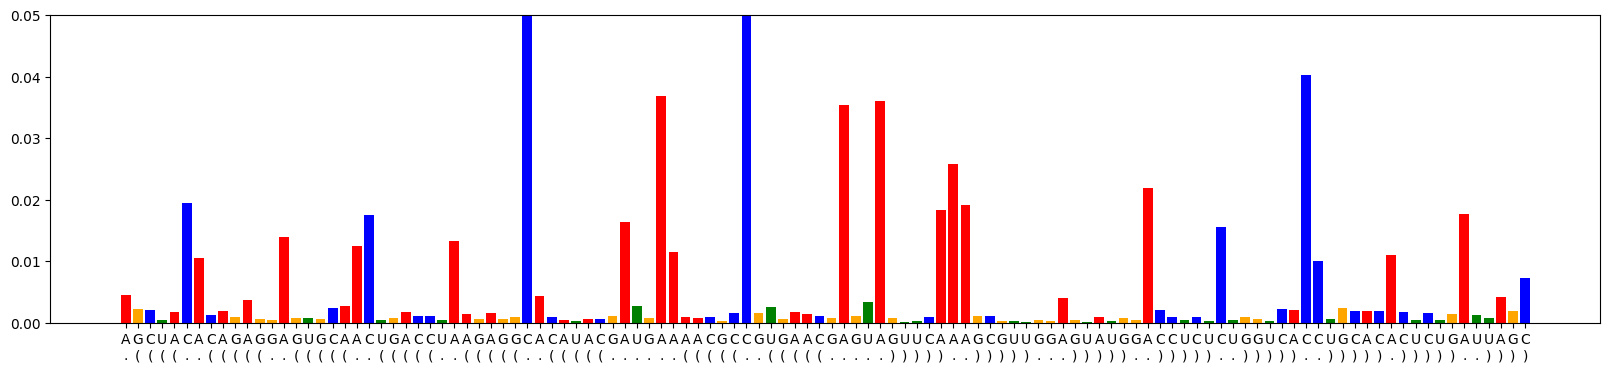

In [43]:
plot_pop_avg_from_row(df_constructs.query('name == "construct793"').iloc[0])
plt.ylim(0, 0.05)

<Axes: >

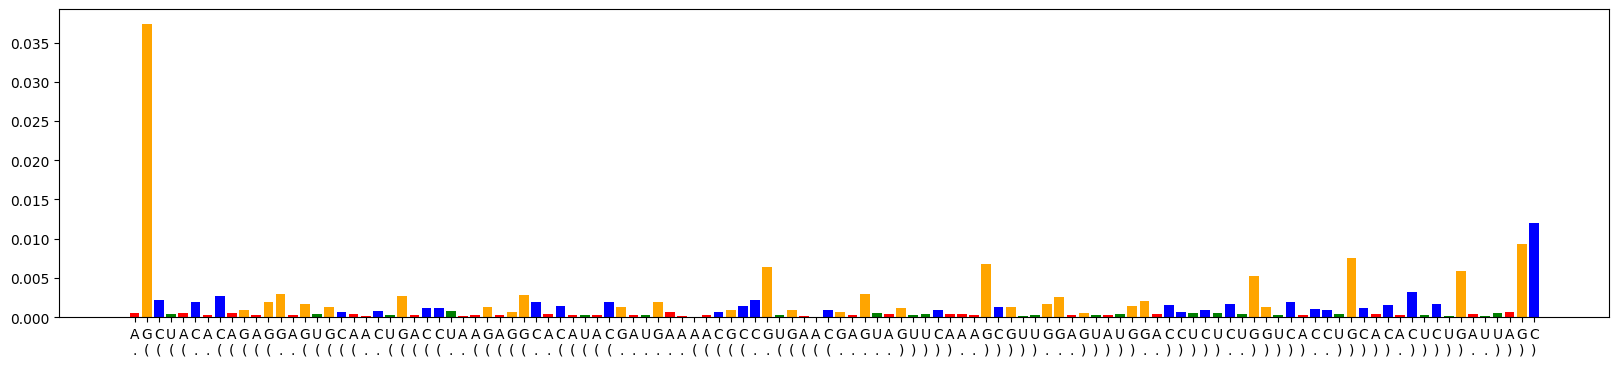

In [44]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct793"').iloc[0])

(0.0, 0.05)

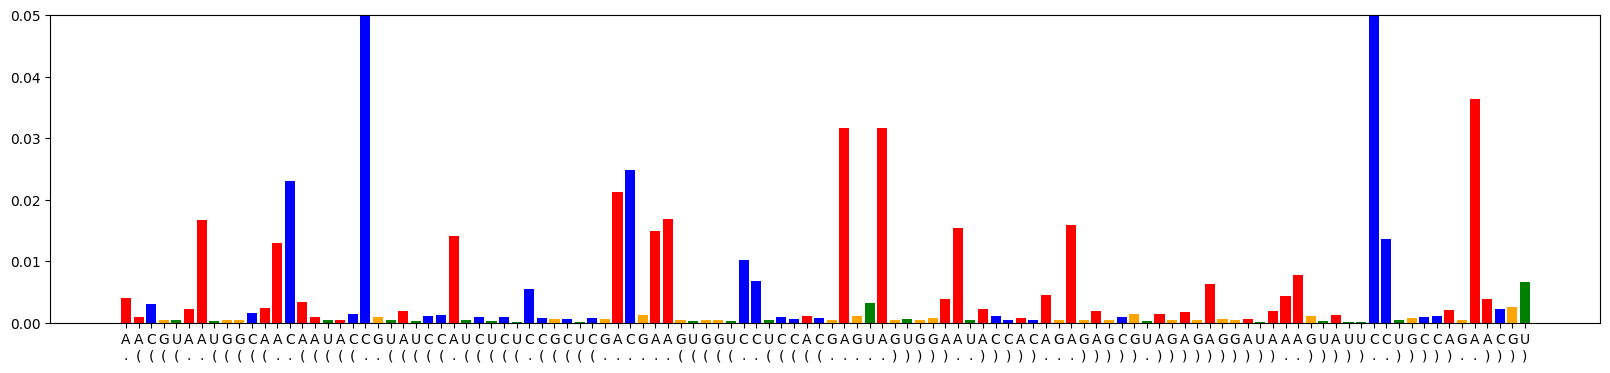

In [45]:
plot_pop_avg_from_row(df_constructs.query('name == "construct884"').iloc[0])
plt.ylim(0, 0.05)

<Axes: >

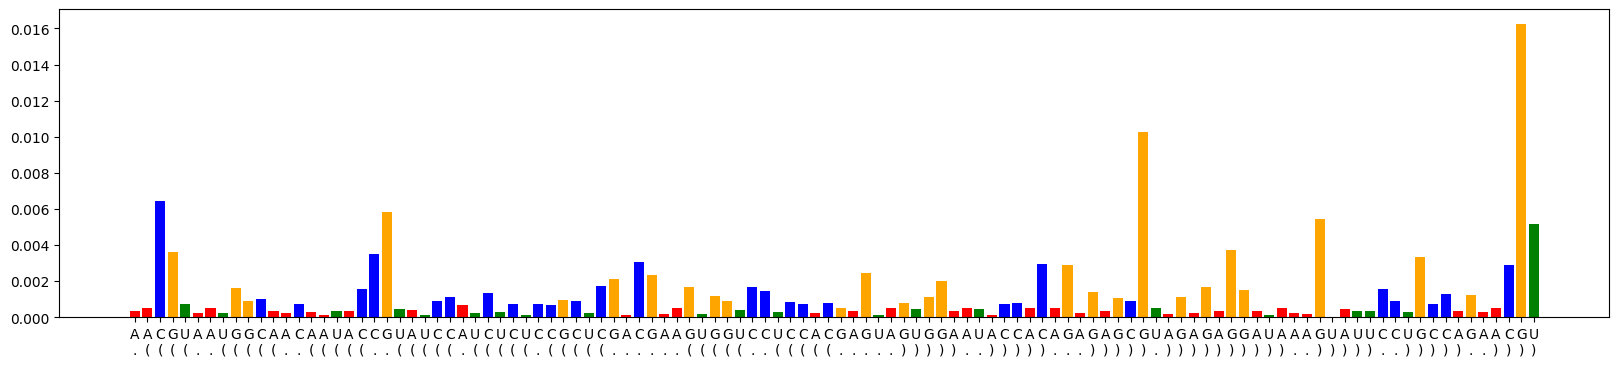

In [46]:
plot_pop_avg_from_row(df_constructs_nomod.query('name == "construct884"').iloc[0])